# My data

If posterior is hopelessly flat, can try fixing some paramters before doing inference. We could justify this well enough for an ecology journal, could argue on basis of 'expert knowledge'.

Could also introduce constraints to the likelihood maximization similar to maxent proccess to account for things estimated from the data (e.g. mortality rates at yr 14) and/or expert knowledge (e.g. Keeley not worried about senescence -> $c_m=0$, non-fire reproduction should go to basically zero after post-fire yr 2).

<!-- Here's a continuous time version, parameter labels have changed:
$\frac{\text{d}N}{\text{d}t}=N\Biggl[ \delta_{t,t_{\text{fire}}}~r_f(N,t^*)~+~\Bigr(1-\delta_{t,t_{\text{fire}}}\Bigl)~\Bigl(r(t^*) - m(N,t^*)\Bigr) \Biggr]$

$m(N,t^*)=m(t^*)\Biggl[ 1~+~\frac{\nu(t^*)}{1+\exp{(~-\gamma~(N-K(t^*)A~)}} \Biggr]$, <br /> -->

with $A$ the area inhabitated by the population (aka patch area). For model fitting, assume patch size of $1~\text{ha}$.

If we assume mortality rates are approximately constant between timesteps (not actually valid, especially for young ages, but probably fine for our purposes), the probablity of an individual of age $a-1$ growing to age $a$ is $e^{-m_{a-1}(\vec{N}(t))}$. To add demographic stochasticity, the number of survivors for a given timestep is drawn as: <br /> $\text{num survivors} \sim Bin\Bigl( e^{(-m_{a-1}(\vec{N})~\epsilon_m)},~N_{a-1}(t) \Bigr)$, <br /> with $\epsilon_m$ a lognormally distributed environmental stochasticity term.

Again assuming a constant rate per timestep, the number of seedlings (i.e. 1 yr olds) can similarly be approximated as: <br /> $\text{num offspring} \sim Poi\Bigl( r(t^*)~\epsilon_r~N(t^*) \Bigr)$.

Reasonable priors for each parameter:
- age-dependent 'baseline' mortality <br /> $m_a = \alpha_m~e^{-\beta_m~a} + \gamma_m$
    - $\alpha_m \sim \mathcal{U}(0.1, 1.8)$  (guess 0.9)
    - $\beta_m \sim \mathcal{U}(0.1, 0.8)$  (guess 0.35)
    - $\gamma_m \sim \mathcal{U}(0,0.1)$  (guess 0.03)
- environmental stochasticity in mortality <br /> $\epsilon_m \sim \text{lognorm}(0,\sigma_m~e^{-\tau_m~a})$
    - log-mean fixed at zero bc we want this centered around 1
    - $\sigma_m \sim \mathcal{U}(0, 0.6)$ (guess 0.1)
    - $\tau_m \sim \mathcal{U}(0, 0.1)$  (guess 0.02)
<!-- - age-dependent maximum mortality  -->
- age-dependent fractional change in survival <br /> $\nu_a = \alpha_{\nu}~e^{-\beta_{\nu}~a} + \gamma_{\nu}$
    - $\alpha_{\nu} \sim \mathcal{U} (0.2, 1.2)$ (guess 0.61854491)
    - $\beta_{\nu} \sim \mathcal{U} (0.05, 0.5)$ (guess 0.18939423)
    - $\gamma_{\nu} \sim \mathcal{U} (0.01, 0.12)$ (guess 0.08853605)
- age-dependent carrying capacity <br /> $K_a = K_{seedling}~e^{-\kappa~a} + K_{adult}$
    - $K_{seedling} \sim \mathcal{U} (4000, 10000)$ (guess 6000)
    - $\kappa \sim \mathcal{U} (0.15, 0.45)$ (guess 0.3)
    - $K_{adult} \sim \mathcal{U} (700, 1300)$ (guess 1024)
- density dependence 'rate' (i.e. logistic function steepness) <br /> $\eta \sim \mathcal{U} (0.01, 0.15)$ (guess 0.1)
- non-fire reproduction rate <br /> $r_{t^*} = e^{-\beta_r~t^*}$
    - $\beta_r \sim \mathcal{U} (0.75,2.5)$ (guess 1.25)
- environmental stochasticity in non-fire reproduction <br /> $\epsilon_r \sim \text{lognorm}(0,\sigma_r~e^{-\tau_r~t^*})$
    - $\sigma_r \sim \mathcal{U} (0.75, 2)$ (guess 0.5)
    - $\tau_r \sim \mathcal{U} (0.1, 2.5)$ (guess 0.4)

For the simulations, we also need to treat the initial population size as a random parameter:
- Initial population size <br /> $N_1(0) \sim \mathcal{U}(200, 14000)$

In [1]:
import torch
import numpy as np
import sbi
from sbi.inference import SNLE, prepare_for_sbi, simulate_for_sbi
from sbi.inference import likelihood_estimator_based_potential, MCMCPosterior
from sbi import utils as utils
from sbi import analysis as analysis
from torch.distributions import Uniform
from sbi.utils import MultipleIndependent
from torch import tensor
import pickle
import pandas as pd
import sys
from matplotlib import pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
import warnings
# warnings.filterwarnings("ignore")
from scipy.stats import moment

#### Check data and store in summary stats in observations.npy

In [2]:
res_len = 5
census_yr_vec = [2,6,8,11,14]
observations = np.empty(5*3)

fn = 'observations/density.csv'
densities_o = pd.read_csv(fn, header=None)
densities_o[0] = [round(v) for v in densities_o[0]]
census_yrs = densities_o[0].to_list()
print([census_yrs.count(v) for v in np.unique(census_yrs)])

fn = 'observations/mortality_avg.csv'
mort_o = pd.read_csv(fn, header=None)
mort_o[0] = [round(v) for v in mort_o[0]]
observations[0:res_len] = mort_o[1].to_numpy()

fn = 'observations/mortality.csv'
mort_o = pd.read_csv(fn, header=None)
mort_o[0] = [round(v) for v in mort_o[0]]
census_yrs = mort_o[0].to_list()
print([census_yrs.count(v) for v in np.unique(census_yrs)])
observations[res_len:res_len*2] = [mort_o[mort_o[0] == yr][1].to_numpy().min() for yr in census_yr_vec]
observations[res_len*2:res_len*3] = [mort_o[mort_o[0] == yr][1].to_numpy().max() for yr in census_yr_vec]

np.save('observations/observations.npy', observations)

[11, 13, 11, 8, 9, 9]
[11, 13, 13, 11, 9]


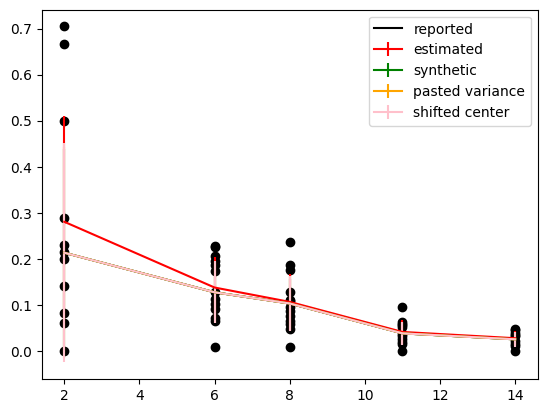

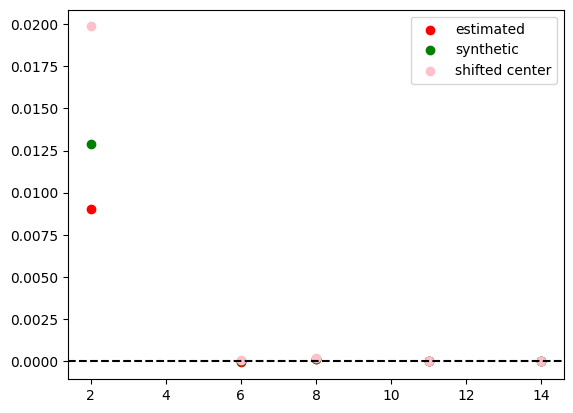

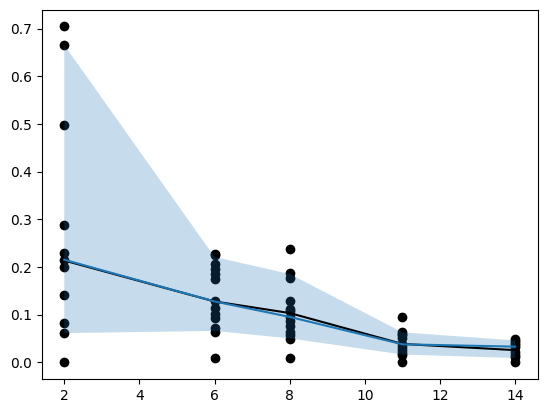

In [37]:
fn = 'observations/mortality.csv'
mortality_o = pd.read_csv(fn, header=None)
mortality_o[0] = [round(v) for v in mortality_o[0]]
plt.scatter(mortality_o[0].to_numpy(), mortality_o[1].to_numpy(), color='k')
fn = 'observations/mortality_avg.csv'
mortality_avg_o = pd.read_csv(fn, header=None)
mortality_avg_o[0] = [round(v) for v in mortality_avg_o[0]]
plt.plot(mortality_avg_o[0].to_numpy(), mortality_avg_o[1].to_numpy(), color='k', label='reported')

census_yrs = [2,6,8,11,14]
m1 = []; m2 = []; m3 = []
m1_adj = []; m2_adj = []; m3_adj = []
m2_shft = []; m3_shft = []
for t_i, t in enumerate(census_yrs):
    mort_sub = mortality_o[mortality_o[0]==t][1].to_numpy()
    est_mean = np.mean(mort_sub)
    m1.append(est_mean)
    m2.append(moment(mort_sub, moment=2))
    m3.append(moment(mort_sub, moment=3))
    # Add 'synthetic' data point to get estimated avg to match reported
    # synthetic = (len(mort_sub) + 1) * (mortality_avg_o[1][t_i]) - np.sum(mort_sub)
    # mort_sub_adj = np.append(mort_sub, [synthetic])
    num_synth = 4  #need at least 4 to make synthetic point non-negative
    synthetic = ((len(mort_sub) + num_synth) * (mortality_avg_o[1][t_i]) - np.sum(mort_sub)) / num_synth
    mort_sub_adj = np.append(mort_sub, np.repeat(synthetic, num_synth))
    # print(synthetic)
    m1_adj.append(np.mean(mort_sub_adj))
    m2_adj.append(moment(mort_sub_adj, moment=2))
    m3_adj.append(moment(mort_sub_adj, moment=3))
    # Try computing higher moments assuming reported average
    m2_shft.append(moment(mort_sub, moment=2, center=mortality_avg_o[1][t_i]))
    m3_shft.append(moment(mort_sub, moment=3, center=mortality_avg_o[1][t_i]))
plt.errorbar(census_yrs, m1, yerr=np.sqrt(m2), color='r', label='estimated')
plt.errorbar(census_yrs, m1_adj, yerr=np.sqrt(m2_adj), color='g', label='synthetic')  #std below zero
plt.errorbar(census_yrs, mortality_avg_o[1].to_numpy(), yerr=np.sqrt(m2), color='orange', label='pasted variance') #std below zero
plt.errorbar(census_yrs, mortality_avg_o[1].to_numpy(), yerr=np.sqrt(m2_shft), color='pink', label='shifted center') #std below zero
plt.legend()
plt.show()
plt.scatter(census_yrs, m3, c='r', label='estimated')
plt.scatter(census_yrs, m3_adj, c='g', label='synthetic')
plt.scatter(census_yrs, m3_shft, c='pink', label='shifted center')
plt.axhline(0, ls='--', color='k')
plt.legend()
plt.show()
plt.scatter(mortality_o[0].to_numpy(), mortality_o[1].to_numpy(), color='k')
plt.plot(mortality_avg_o[0].to_numpy(), mortality_avg_o[1].to_numpy(), color='k')
mort_subs = [mortality_o[mortality_o[0]==t][1].to_numpy() for t in census_yrs]
percentiles = np.empty((2, len(census_yrs)))
percentiles[0] = [np.percentile(ms, 10) for ms in mort_subs]
percentiles[1] = [np.percentile(ms, 90) for ms in mort_subs]
medians = [np.median(ms) for ms in mort_subs]
plt.plot(census_yrs, medians)
# plt.errorbar(census_yrs, medians, yerr=percentiles)
plt.fill_between(census_yrs, percentiles[0], percentiles[1], alpha=0.25)

In [152]:
# Save new summary stats to observations.npy
# observations = np.concatenate((m1,m2,m3))
# np.save('observations/observations.npy', observations)

#### Playing with parameters

In [26]:
def simulator(params):
    # Assign parameter labels
    alph_m = params[0]; beta_m = params[1]; gamm_m = params[2]
    sigm_m = params[3]; tau_m = params[4]
    alph_nu = params[5]; beta_nu = params[6]; gamm_nu = params[7]
    K_seedling = params[8]; kappa = params[9]; K_adult = params[10]
    eta = params[11]
    mu_m = params[12]

    # For generating env stochasticity multipliers
    rng = np.random.default_rng()

    # Initialize empty results array
    census_yrs = np.array([1,2,6,8,11,14])
    res_len = len(census_yrs) - 1
    results = np.empty(res_len * 3)
    res_i = 0

    t_vec = np.arange(1,15)
    fn = 'observations/density.csv'
    densities_o = pd.read_csv(fn, header=None)
    densities_o[0] = [round(v) for v in densities_o[0]]
    N_0_1 = densities_o[densities_o[0] == 1][1].to_numpy()
    N_vec = np.ma.array(np.zeros((len(N_0_1), len(t_vec))))
    N_vec[:,0] = N_0_1
    N_vec = N_vec.astype(int)
    census_init = N_vec.sum(axis=1)
    census_yr_init = t_vec[0]

    m_a = alph_m * np.exp(-beta_m*t_vec) + gamm_m
    # K_a = K_seedling * np.exp(-kappa*t_vec) + K_adult
    K_a = K_adult
    nu_a = alph_nu * np.exp(-beta_nu*t_vec) + gamm_nu

    for age_i, t in enumerate(t_vec[:-1]):
        for pop_i, N_pop in enumerate(N_vec):
            # If pop already extirpated, skip
            if (np.ma.is_masked(N_vec)) and (np.ma.getmask(N_vec)[pop_i, 0]):
                continue
            # Add density dependent term to mortalities
            dens_dep = ((nu_a)*(1-m_a)) / (1 + np.exp(-eta*K_adult*(np.sum(N_pop/K_a) - 1)))
            m_a_N = m_a + dens_dep
            # Draw env. stoch. terms and combine for final survival prob.
            epsilon_m = rng.lognormal(np.zeros_like(t_vec)+mu_m, sigm_m*np.exp(-tau_m*t_vec))
            survival_probs = np.exp(-m_a_N * epsilon_m)
            num_survivors = rng.binomial(N_pop, survival_probs)
            num_survivors = np.roll(num_survivors, 1)
            # Finally, update abundances
            N_vec[pop_i] = num_survivors
            # Note if population was extirpated
            if np.sum(num_survivors) == 0:
                N_vec[pop_i, :] = np.ma.masked
                census_init[pop_i] = np.ma.masked
        # If enough populations extirpated, consider parameter set invalid
        if (np.ma.is_masked(N_vec)) and (sum(np.ma.getmask(N_vec)[:,0]) > 3):
            results[0:res_len] = np.ones(len(census_yrs)-1)*10
            results[res_len:res_len*2] = np.ones(len(census_yrs)-1)*20
            results[res_len*2:res_len*3] = np.ones(len(census_yrs)-1)*20
            break
        elif t+1 in census_yrs:
            # Calculate and store mortality stats
            delta_t = (t+1) - census_yr_init
            census_final = N_vec.sum(axis=1)
            mortality = ((census_init - census_final) / census_init) / delta_t
            results[res_i] = np.mean(mortality)
            results[res_len + res_i] = moment(mortality, moment=2)
            results[res_len*2 + res_i] = moment(mortality, moment=3)
            # Reset for next census
            res_i += 1
            census_init = census_final
            census_yr_init = t+1
    return results

In [124]:
def plt_sim(alph_m = 0.9, beta_m = 0.35, gamm_m = 0.03,
            sigm_m = 0.1, tau_m = 0.02,
            alph_nu = 0.6185, beta_nu = 0.189, gamm_nu = 0.088,
            K_seedling = 6000*10, kappa = 0.3, K_adult = 1024*10, eta = 0.1, mu_m = 0.0):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    census_yrs = [2,6,8,11,14]
    fn = 'observations/mortality.csv'
    mortality_o = pd.read_csv(fn, header=None)
    mortality_o[0] = [round(v) for v in mortality_o[0]]
    # plt.scatter(mortality_o[0].to_numpy(), mortality_o[1].to_numpy(), color='k')
    # fn = 'observations/mortality_avg.csv'
    # mortality_avg_o = pd.read_csv(fn, header=None)
    # mortality_avg_o[0] = [round(v) for v in mortality_avg_o[0]]
    # plt.plot(mortality_avg_o[0].to_numpy(), mortality_avg_o[1].to_numpy(), color='k')
    m1 = []; m2 = []; m3 = []
    for t_i, t in enumerate(census_yrs):
        mort_sub = mortality_o[mortality_o[0]==t][1].to_numpy()
        est_mean = np.mean(mort_sub)
        m1.append(est_mean)
        m2.append(moment(mort_sub, moment=2))
        m3.append(moment(mort_sub, moment=3))
    ax1.errorbar(census_yrs, m1, yerr=np.sqrt(m2), color='k', fmt='o')
    
    params = [alph_m, beta_m, gamm_m, sigm_m, tau_m, alph_nu, 
              beta_nu, gamm_nu, K_seedling, kappa, K_adult, eta, mu_m]
    reps = 100
    num_invalid = 0
    all_res = np.zeros((reps,3*5))
    for rep in range(reps):
        res = simulator(params)
        if np.all(res[0:5] == 10):
            num_invalid += 1
            continue
        all_res[rep] = res
    all_res = np.delete(all_res, -num_invalid, axis=0)
    res = np.mean(all_res, axis=0)
    print('{} sims with >3 extirpations'.format(num_invalid))
    plt.axhline(0, ls='--', color='k')
    # plt.plot(census_yrs, res[0:5])
    # plt.fill_between(census_yrs, res[5:10], res[10:15], alpha=0.25)
    # ax1.errorbar(census_yrs, res[0:5], yerr=np.sqrt(res[5:10]), fmt='o', alpha=0.75, c='magenta')
    ax1.scatter(census_yrs, res[0:5], c='magenta', alpha=0.75)
    ax1.fill_between(census_yrs, res[0:5]-np.sqrt(res[5:10]), res[0:5]+np.sqrt(res[5:10]), color='magenta', alpha=0.2)
    ax1.set_ylim(-0.1,0.8)
    
    ax2.scatter(census_yrs, m3, c='k')
    ax2.scatter(census_yrs, res[10:15], alpha=0.75, c='magenta')
    
defaults = np.array([0.9,0.35,0.03,0.1,0.02,0.6185,0.189,0.088,6000*10,0.3,1024*10,0.1,0.0])
interact(plt_sim,
         alph_m = widgets.FloatSlider(value=0.25, min=0.01, max=defaults[0]*1.75, step=defaults[0]/40, continuous_update=False),#
         beta_m = widgets.FloatSlider(value=0.26, min=0.01, max=0.9, step=0.01, continuous_update=False),
         gamm_m = widgets.FloatSlider(value=0.01, min=defaults[2]*0.25, max=defaults[2]*1.75, step=defaults[2]/40, continuous_update=False),
         sigm_m = widgets.FloatSlider(value=0.9, min=0., max=1.7, step=defaults[3]/40, continuous_update=False),#
         tau_m = widgets.FloatSlider(value=0.01, min=0.0, max=0.4, step=defaults[4]/40, continuous_update=False),
         alph_nu = widgets.FloatSlider(value=0.75, min=0.01, max=3, step=defaults[5]/40, continuous_update=False),#
         beta_nu = widgets.FloatSlider(value=0.1, min=defaults[6]*0.25, max=defaults[6]*1.75, step=defaults[6]/40, continuous_update=False),
         gamm_nu = widgets.FloatSlider(value=0.1, min=defaults[7]*0.25, max=defaults[7]*1.75, step=defaults[7]/40, continuous_update=False),
         K_seedling = widgets.FloatSlider(value=60000, min=1000, max=defaults[8]*5, step=10, continuous_update=False),
         kappa = widgets.FloatSlider(value=0.4, min=0.01, max=0.9, step=defaults[9]/40, continuous_update=False),
         K_adult = widgets.FloatSlider(value=defaults[10], min=defaults[10]*0.25, max=60000, step=10, continuous_update=False),
         eta = widgets.FloatSlider(value=0.02, min=0.01, max=0.6, step=defaults[11]/40, continuous_update=False),
         mu_m = widgets.FloatSlider(value=0.0, min=-0.2, max=0.1, step=0.01, continuous_update=False))
defaults = np.array([0.2, 0.8, 0.45])
# n = 200
# widths = [(v*1.9-v*0.1)/(2*n) for v in defaults]; print(widths)
ranges = np.array([[0.01, 0.6], [0.1,0.9], [0.05,0.95]])
fixed = {'beta_m': 0.26, 'gamm_m': 0.01, 'tau_m': 0.01, 'beta_nu': 0.1, 'gamm_nu': 0.1, 
         'K_seedling': 60000, 'kappa': 0.4, 'K_adult': 10000, 'eta': 0.02, 'mu_m': 0.0}

interactive(children=(FloatSlider(value=0.25, continuous_update=False, description='alph_m', max=1.575, min=0.…

In [27]:
def plt_sim(alph_m = 0.9, beta_m = 0.35, gamm_m = 0.03,
            sigm_m = 0.1, tau_m = 0.02,
            alph_nu = 0.6185, beta_nu = 0.189, gamm_nu = 0.088,
            K_adult = 1024*10, eta = 0.1, mu_m = 0.0):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    census_yrs = [2,6,8,11,14]
    fn = 'observations/mortality.csv'
    mortality_o = pd.read_csv(fn, header=None)
    mortality_o[0] = [round(v) for v in mortality_o[0]]
    m1 = []; m2 = []; m3 = []
    for t_i, t in enumerate(census_yrs):
        mort_sub = mortality_o[mortality_o[0]==t][1].to_numpy()
        est_mean = np.mean(mort_sub)
        m1.append(est_mean)
        m2.append(moment(mort_sub, moment=2))
        m3.append(moment(mort_sub, moment=3))
    ax1.errorbar(census_yrs, m1, yerr=np.sqrt(m2), color='k', fmt='o')
    
    params = [alph_m, beta_m, gamm_m, sigm_m, tau_m, alph_nu, 
              beta_nu, gamm_nu, 6000*10, 0.3, K_adult, eta, mu_m]
    reps = 100
    num_invalid = 0
    all_res = np.zeros((reps,3*5))
    for rep in range(reps):
        res = simulator(params)
        if np.all(res[0:5] == 10):
            num_invalid += 1
            continue
        all_res[rep] = res
    all_res = np.delete(all_res, -num_invalid, axis=0)
    res = np.mean(all_res, axis=0)
    print('{} sims with >3 extirpations'.format(num_invalid))
    plt.axhline(0, ls='--', color='k')
    ax1.scatter(census_yrs, res[0:5], c='magenta', alpha=0.75)
    ax1.fill_between(census_yrs, res[0:5]-np.sqrt(res[5:10]), res[0:5]+np.sqrt(res[5:10]), color='magenta', alpha=0.2)
    ax1.set_ylim(-0.1,0.8)
    
    ax2.scatter(census_yrs, m3, c='k')
    ax2.scatter(census_yrs, res[10:15], alpha=0.75, c='magenta')
    
defaults = np.array([0.9,0.35,0.03,0.1,0.02,0.6185,0.189,0.088,6000*10,0.3,1024*10,0.1,0.0])
interact(plt_sim,
         alph_m = widgets.FloatSlider(value=0.22, min=0.01, max=0.6, step=0.01, continuous_update=False),
         beta_m = widgets.FloatSlider(value=0.25, min=0.01, max=0.6, step=defaults[1]/40, continuous_update=False),
         gamm_m = widgets.FloatSlider(value=0.01, min=defaults[2]*0.25, max=defaults[2]*1.75, step=defaults[2]/40, continuous_update=False),
         sigm_m = widgets.FloatSlider(value=0.8, min=0., max=1.7, step=defaults[3]/40, continuous_update=False),
         tau_m = widgets.FloatSlider(value=0.01, min=0.0, max=0.4, step=defaults[4]/40, continuous_update=False),
         alph_nu = widgets.FloatSlider(value=0.4, min=0.0, max=3, step=0.01, continuous_update=False),
         beta_nu = widgets.FloatSlider(value=0.11, min=defaults[6]*0.25, max=defaults[6]*1.75, step=defaults[6]/40, continuous_update=False),
         gamm_nu = widgets.FloatSlider(value=0.1, min=defaults[7]*0.25, max=defaults[7]*1.75, step=defaults[7]/40, continuous_update=False),
         K_adult = widgets.FloatSlider(value=16000, min=defaults[10]*0.25, max=60000, step=10, continuous_update=False),
         eta = widgets.FloatSlider(value=0.02, min=0.01, max=0.6, step=defaults[11]/40, continuous_update=False),
         mu_m = widgets.FloatSlider(value=0.0, min=-0.2, max=0.1, step=0.01, continuous_update=False))
# defaults = np.array([0.2, 0.8, 0.45])
# ranges = np.array([[0.01, 0.6], [0.1,0.9], [0.05,0.95]])
# fixed = {'beta_m': 0.26, 'gamm_m': 0.01, 'tau_m': 0.01, 'beta_nu': 0.1, 'gamm_nu': 0.1, 
#          'K_seedling': 60000, 'kappa': 0.4, 'K_adult': 10000, 'eta': 0.02, 'mu_m': 0.0}

interactive(children=(FloatSlider(value=0.22, continuous_update=False, description='alph_m', max=0.6, min=0.01…

<function __main__.plt_sim(alph_m=0.9, beta_m=0.35, gamm_m=0.03, sigm_m=0.1, tau_m=0.02, alph_nu=0.6185, beta_nu=0.189, gamm_nu=0.088, K_adult=10240, eta=0.1, mu_m=0.0)>

#### posterior pairplot

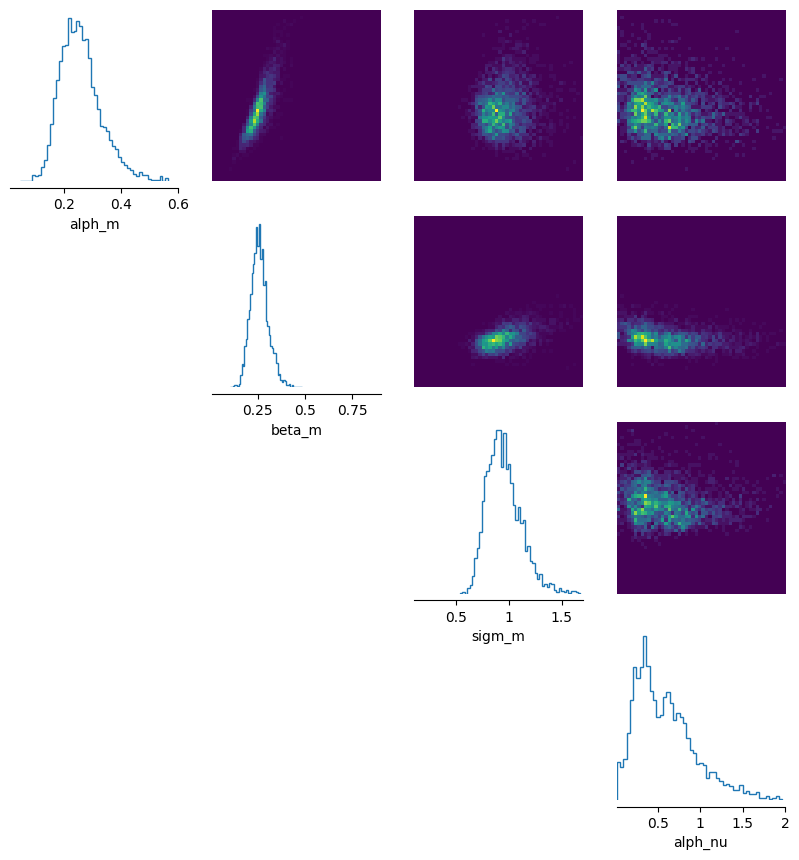

In [10]:
limits = [[0.01, 0.6], [0.01, 0.9], [0.1,1.7], [0.01,2.]]
labels = ['alph_m', 'beta_m', 'sigm_m','alph_nu']
nle_samples = torch.load('posterior_samples_test.pkl')
_ = analysis.pairplot(
    nle_samples, limits=limits, figsize=(10, 10), labels=labels
)

#### restricted prior pairplot

In [2]:
with open('prior.pkl', 'rb') as handle:
    prior = pickle.load(handle)

The `RestrictedPrior` rejected 1.4%
                of prior samples. You will get a speed-up of
                1.4%.


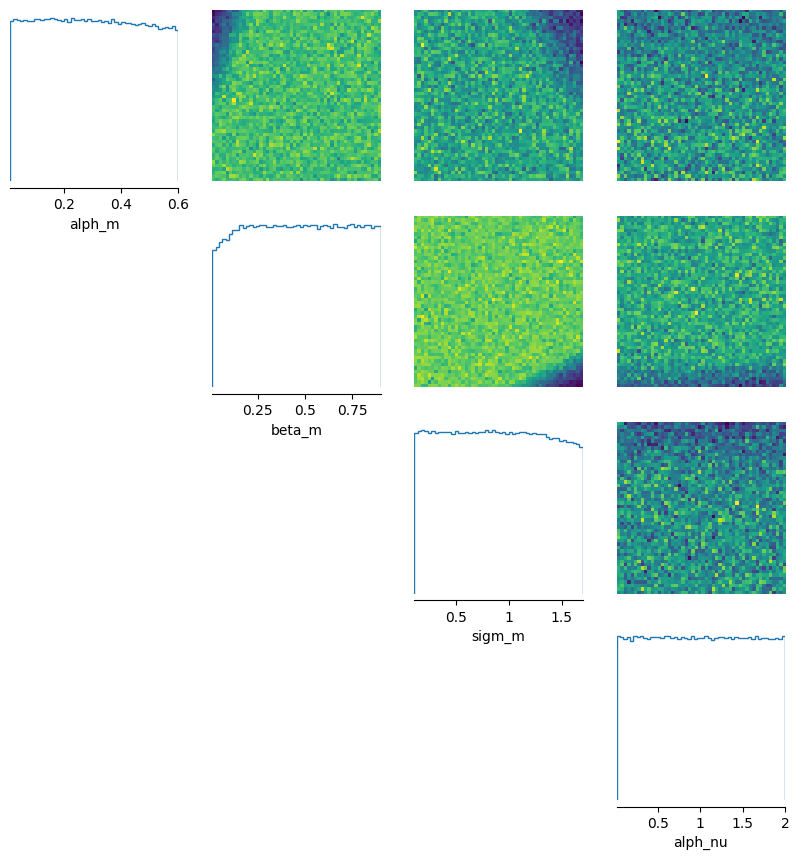

In [3]:
limits = [[0.01, 0.6], [0.01, 0.9], [0.1,1.7], [0.01,2.]]
labels = ['alph_m', 'beta_m', 'sigm_m','alph_nu']
prior_samples = prior.sample((1_000_000,))
_ = analysis.pairplot(
    prior_samples, limits=limits, figsize=(10, 10), labels=labels
)

#### posterior validation

In [4]:
from simulator import simulator

In [9]:
# ranges = np.array([
#                    # alph_m
#                    [0.01, 0.6], 
#                    # beta_m
#                    [0.01, 0.9], 
#                    # sigm_m
#                    [0.1,1.7], 
#                    # alph_nu
#                    [0.01,2.]
# ])
# priors = [Uniform(tensor([rng[0]]), tensor([rng[1]])) for rng in ranges]
# prior = MultipleIndependent(priors)
# prior, theta_numel, prior_returns_numpy = utils.user_input_checks.process_prior(prior)
with open('prior.pkl', 'rb') as handle:
    prior = pickle.load(handle)
# prior, theta_numel, prior_returns_numpy = utils.user_input_checks.process_prior(prior)
# simulator = utils.user_input_checks.process_simulator(simulator, prior, is_numpy_simulator=True)

In [4]:
# Read likelihood estimator from file
with open("likelihood_estimator_big.pkl", "rb") as handle:
    likelihood_estimator = pickle.load(handle)

x_o = np.load('observations/observations.npy')
x_o = torch.Tensor(x_o)
potential_fn, parameter_transform = likelihood_estimator_based_potential(
    likelihood_estimator, prior, x_o
)
mcmc_parameters = dict(
    method = "slice_np_vectorized",
    num_chains=20,
    thin=10,
    warmup_steps=50,
    init_strategy="proposal"
)
posterior = MCMCPosterior(
    potential_fn, proposal=prior, **mcmc_parameters
)

In [30]:
x_o = np.load('observations/observations.npy')
x_o = torch.Tensor(x_o)
with open("posterior.pkl", "rb") as handle:
    posterior = pickle.load(handle)

##### ppc

In [31]:
posterior_samples = posterior.sample(sample_shape=(5000,))
x_pp = simulator(posterior_samples)

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

In [22]:
nle_samples = torch.load('posterior_samples_big.pkl')
x_pp = simulator(nle_samples[-5000:])

In [20]:
x_pp.amin(0)

tensor([ 9.8171e-02,  3.0181e-02,  1.2843e-02,  1.2093e-02,  6.8545e-03,
         3.2237e-03,  3.4595e-04,  6.9348e-05,  2.6273e-05,  1.6696e-05,
        -3.8384e-02, -5.4231e-04, -1.5445e-04, -3.2081e-05, -1.7732e-05])

In [36]:
x_pp.amax(0)

tensor([1.0000e+01, 1.0000e+01, 1.0000e+01, 1.0000e+01, 1.0000e+01, 2.0000e+01,
        2.0000e+01, 2.0000e+01, 2.0000e+01, 2.0000e+01, 7.0729e-02, 9.0419e-04,
        7.3610e-03, 2.0974e-03, 2.1004e-03])

In [19]:
lim_scale = 1.0
mins = x_pp.amin(0)
maxes = x_pp.amax(0)
limits = torch.tensor([[mins[i]*lim_scale, maxes[i]*lim_scale] for i in range(x_pp.shape[1])])
limits[9][0] = -0.0005; limits[9][1] = 0.001
limits[12][0] = -0.0005; limits[12][1] = 0.0008
limits[13][0] = -0.00005; limits[13][1] = 0.00015
limits[14][0] = -0.00005; limits[14][1] = 0.0001

NameError: name 'x_pp' is not defined

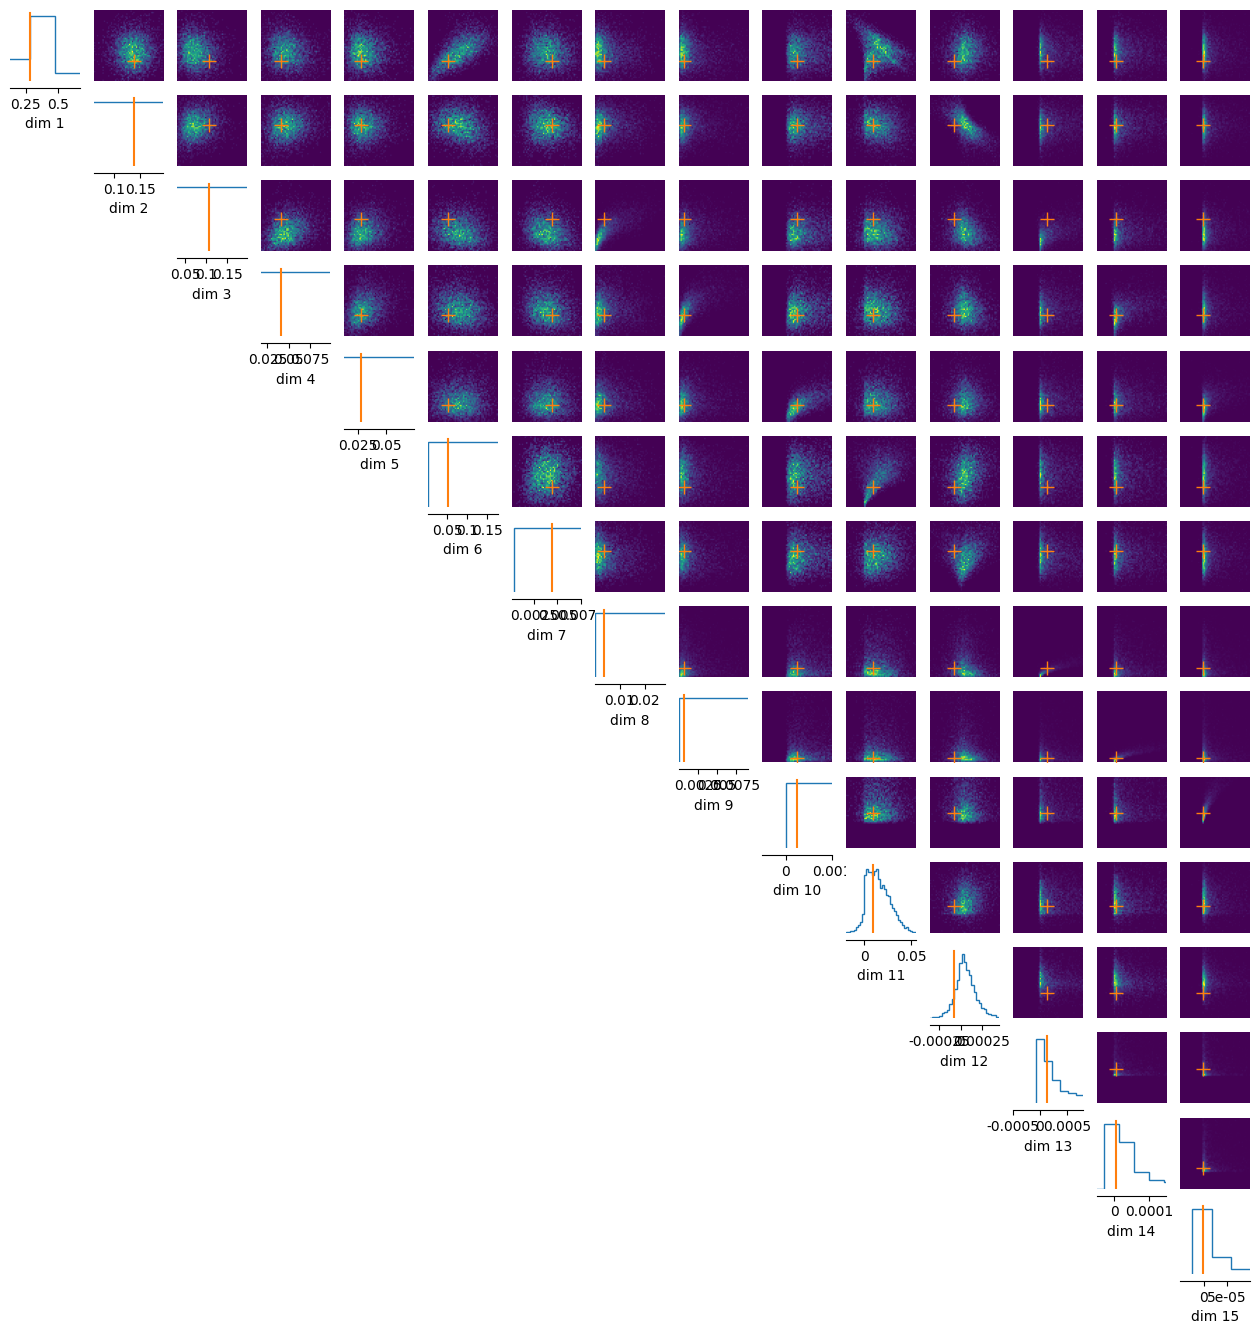

In [35]:
ppc = analysis.pairplot(
    samples=x_pp,
    points=x_o, 
    points_offdiag=dict(marker="+", markersize=10),
    limits=limits,
    figsize=(16,16)
)
# ppc[0].savefig('figs/ppc.png', bbox_inches='tight')

##### sbc

In [19]:
num_simulations = 300  # choose a number of sbc runs, should be ~100s or ideally 1000
# generate ground truth parameters and corresponding simulated observations for SBC.
thetas = prior.sample((num_simulations,))
xs = simulator(thetas)

In [20]:
num_posterior_samples = 1_000
ranks, dap_samples = analysis.sbc.run_sbc(
    thetas, xs, posterior, num_posterior_samples=num_posterior_samples,
    num_workers=1, reduce_fns=posterior.log_prob,
)

/Volumes/External/Research/Regan/TecateCypress/model_fitting/sbi/analysis/sbc.py:57: UserWarning: Number of SBC samples should be on the order of 100s to give realiable
            results. We recommend using 300.
  warnings.warn(


Running 300 sbc samples.:   0%|          | 0/300 [00:00<?, ?it/s]

/Volumes/External/Research/Regan/TecateCypress/model_fitting/sbi/inference/posteriors/mcmc_posterior.py:172: UserWarning: `.log_prob()` is deprecated for methods that can only evaluate the
            log-probability up to a normalizing constant. Use `.potential()` instead.
  warn(
/Volumes/External/Research/Regan/TecateCypress/model_fitting/sbi/inference/posteriors/mcmc_posterior.py:176: UserWarning: The log-probability is unnormalized!
  warn("The log-probability is unnormalized!")


KeyboardInterrupt: 

In [2]:
import psutil
psutil.virtual_memory().available * 100 / psutil.virtual_memory().total

44.65312957763672